In [11]:
# =========================================
# BLOCO 1 — SETUP + CONFIG
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

np.seterr(divide="ignore", invalid="ignore")
np.set_printoptions(suppress=False)

# ---- CONFIG (edite só aqui) ----
RUN_PSO = True           # True = roda PSO e depois visualiza o melhor
ARTICLE_MODE = False     # True = N execuções (estatístico); False = 1 execução
N_RUNS = 30              # usado se ARTICLE_MODE=True
SEED_SINGLE = 42         # usado se ARTICLE_MODE=False
SHOW_ARTICLE_PLOTS = True
VISUALIZE_BEST = True

# Se RUN_PSO=False, cole manualmente aqui o best_position (9 vars):
MANUAL_BEST_POSITION = np.array([
    # scale_square, sq_reduction_factor, zexp, D1, D2, D3, t1, t2, t3
], dtype=float)


In [12]:
# =========================================
# BLOCO 2 — CONSTANTES / MATERIAIS
# =========================================
E = 200e9          # Pa
lrt = 2e9          # Pa
lrc = 700e6        # Pa
rho = 2000         # kg/m3
K_eff = 0.8

max_length = 0.85  # m
load_mag = 60      # N


In [13]:
# =========================================
# BLOCO 3 — GEOMETRIA BASE (quadrado + conectividades)
# =========================================
square = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [1, 1, 0],
    [1, 0, 0]
], dtype=float) - np.array([0.5, 0.5, 0.0], dtype=float)

square_conn = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0]
], dtype=int)

z_conn = np.arange(8).reshape(2, -1).T.astype(int)  # [[0,4],[1,5],[2,6],[3,7]]
diag_conn = ((z_conn + np.array([1, 0], dtype=int)) % np.array([4, int(1e9)])).astype(int)

z_axis = np.array([0.0, 0.0, 1.0], dtype=float)
ksign = np.array([[1, -1], [-1, 1]], dtype=float).repeat(3, axis=0).repeat(3, axis=1)


In [14]:
# =========================================
# BLOCO 4 — HELPERS (colormap + escala 3D + "fabricável")
# =========================================
def get_cmap_safe(name="managua", fallback="viridis"):
    try:
        return cm.get_cmap(name)
    except Exception:
        return cm.get_cmap(fallback)

def set_axes_equal_3d(ax, nodes):
    x = nodes[:, 0]; y = nodes[:, 1]; z = nodes[:, 2]
    x_range = x.max() - x.min()
    y_range = y.max() - y.min()
    z_range = z.max() - z.min()
    mid_x = 0.5 * (x.max() + x.min())
    mid_y = 0.5 * (y.max() + y.min())
    mid_z = 0.5 * (z.max() + z.min())
    max_range = max(x_range, y_range, z_range, 1e-12)
    ax.set_xlim(mid_x - 0.5 * max_range, mid_x + 0.5 * max_range)
    ax.set_ylim(mid_y - 0.5 * max_range, mid_y + 0.5 * max_range)
    ax.set_zlim(mid_z - 0.5 * max_range, mid_z + 0.5 * max_range)
    try:
        ax.set_box_aspect((1, 1, 1))
    except Exception:
        pass

def make_fabricable(diam_o, diam_i):
    diam_o = np.asarray(diam_o, dtype=float).copy()
    diam_i = np.asarray(diam_i, dtype=float).copy()

    thickness = np.round(4000.0 * (diam_o - diam_i) / 2.0) / 4000.0
    diam_o = np.ceil(2000.0 * diam_o) / 2000.0
    diam_i = diam_o - 2.0 * thickness

    diam_i[diam_i < 0] = 0.0
    mask_bad = diam_i >= diam_o
    if np.any(mask_bad):
        diam_i[mask_bad] = np.maximum(diam_o[mask_bad] - 1e-6, 0.0)

    return diam_o, diam_i

def print_sections(diam_o, diam_i):
    tube_position = ["Secondary element", "Primary element", "Diagonal element"]
    for desc, do, di in zip(tube_position, diam_o, diam_i):
        if di > 0.0:
            print(f"{desc} = Tube, diameter: {1000*do:.2f} mm | thickness: {500*(do-di):.2f} mm")
        else:
            print(f"{desc} = Rod, diameter: {1000*do:.2f} mm")
    print()


In [15]:
# =========================================
# BLOCO 5 — GEOMETRIA (gera nós, elementos, tipo)
# =========================================
def generate_geometry(scale_square, sq_reduction_factor, zdist, total_length):
    nodes = []
    elements = []
    element_kind = []

    zdiv = len(zdist)
    sfunc = (1 - zdist) * scale_square + (zdist) * scale_square / float(sq_reduction_factor)

    for i in range(zdiv):
        sq0 = square * sfunc[i] + zdist[i] * z_axis * total_length
        nodes.append(sq0)

        sq_conn0 = square_conn + i * 4
        elements.append(sq_conn0)
        element_kind.append(0 * np.ones(4))

        if i < zdiv - 1:
            z_conn0 = z_conn + i * 4
            diag_conn0 = diag_conn + i * 4
            elements.append(z_conn0)
            element_kind.append(1 * np.ones(4))
            elements.append(diag_conn0)
            element_kind.append(2 * np.ones(4))

    nodes = np.concatenate(nodes, axis=0)
    elements = np.concatenate(elements, axis=0).astype(int)
    element_kind = np.concatenate(element_kind, axis=0).astype(int)
    return nodes, elements, element_kind


In [16]:
# =========================================
# BLOCO 6 — FEM (montagem + solver)
# =========================================
def build_system(nodes, elements, element_kind, diam_o, diam_i, rho_, load_mag_, zdist):
    num_nodes = nodes.shape[0]
    n_dofs = 3 * num_nodes

    dofs = (3 * elements.reshape(-1, 2, 1) +
            np.array([0, 1, 2]).reshape(1, 1, 3)).reshape(-1, 6)

    element_diam_ext = np.zeros_like(element_kind, dtype=float)
    element_diam_int = np.zeros_like(element_kind, dtype=float)

    element_diam_ext[element_kind == 0] = diam_o[0]
    element_diam_ext[element_kind == 1] = diam_o[1]
    element_diam_ext[element_kind == 2] = diam_o[2]

    element_diam_int[element_kind == 0] = diam_i[0]
    element_diam_int[element_kind == 1] = diam_i[1]
    element_diam_int[element_kind == 2] = diam_i[2]

    element_area = 0.25 * np.pi * (element_diam_ext**2 - element_diam_int**2)
    element_I = (1.0 / 64.0) * np.pi * (element_diam_ext**4 - element_diam_int**4)

    dxyz = (nodes[elements] * np.array([1.0, -1.0]).reshape(1, 2, 1)).sum(axis=1)
    element_length = np.sqrt(np.sum(dxyz**2, axis=1))
    total_mass = float((element_length * element_area * float(rho_)).sum())

    fixed_nodes = np.array([0, 1, 2, 3], dtype=int)
    constraints = np.ones((len(fixed_nodes), 3), dtype=bool)

    load_nodes = np.array([
        [len(zdist) * 4 - 1, 1],
        [len(zdist) * 4 - 4, 1],
    ], dtype=int)
    load_magnitudes = np.array([float(load_mag_) / 2.0, float(load_mag_) / 2.0], dtype=float)

    return (dofs, n_dofs, element_area, element_I, element_length, dxyz,
            constraints, fixed_nodes, load_nodes, load_magnitudes, total_mass)

def build_K_global(dofs, n_dofs, element_area, element_length, dxyz, E_):
    E_ = float(E_)
    k_block = (element_area.reshape(-1, 1, 1) * E_) * \
              (dxyz.reshape(-1, 3, 1) * dxyz.reshape(-1, 1, 3)) / \
              (element_length.reshape(-1, 1, 1) ** 3)
    k = (np.tile(k_block, (1, 2, 2)) * ksign)

    n_el = len(element_area)
    K_stack = np.zeros((n_el, n_dofs, n_dofs), dtype=float)

    dofs_xy = np.outer(dofs, np.ones((1, 6))).reshape(*dofs.shape, 6).astype(int)
    idx_el = np.outer(np.arange(n_el), np.ones((1, 6, 6))).reshape(-1, 6, 6).astype(int)

    K_stack[idx_el, dofs_xy, dofs_xy.transpose((0, 2, 1))] = k
    return K_stack.sum(axis=0)

def build_F_global(load_nodes, load_magnitudes, n_dofs):
    F_global = np.zeros(int(n_dofs), dtype=float)
    F_global[3 * load_nodes[:, 0] + load_nodes[:, 1]] = load_magnitudes
    return F_global

def apply_constraints(K_global, F_global, constraints, fixed_nodes, n_dofs):
    constrained_dofs = (3 * fixed_nodes.reshape(-1, 1) +
                        np.array([0, 1, 2]).reshape(1, 3))[constraints].astype(int)

    unconstrained_mask = np.ones(int(n_dofs), dtype=bool)
    unconstrained_mask[constrained_dofs] = False
    unconstrained = np.arange(int(n_dofs))[unconstrained_mask]

    K_reduced = K_global[np.ix_(unconstrained, unconstrained)]
    F_reduced = F_global[unconstrained]
    return K_reduced, F_reduced, unconstrained

def solve_fem(K_reduced, F_reduced, unconstrained_dofs, n_dofs):
    U_reduced = np.linalg.solve(K_reduced, F_reduced)
    U_global = np.zeros(int(n_dofs), dtype=float)
    U_global[np.asarray(unconstrained_dofs, dtype=int)] = U_reduced
    return U_global

def structural_analysis(dofs, n_dofs, element_area, element_length, dxyz,
                        constraints, fixed_nodes, load_nodes, load_magnitudes, E_):
    K_global = build_K_global(dofs, n_dofs, element_area, element_length, dxyz, E_)
    F_global = build_F_global(load_nodes, load_magnitudes, n_dofs)
    K_reduced, F_reduced, unconstrained = apply_constraints(K_global, F_global, constraints, fixed_nodes, n_dofs)
    return solve_fem(K_reduced, F_reduced, unconstrained, n_dofs)


In [17]:
# =========================================
# BLOCO 7 — PÓS-PROCESSAMENTO (forças, tensões, SFs)
# =========================================
def member_quantities(U_global, dofs, dxyz, element_length, element_area, E_):
    E_ = float(E_)
    Ue = U_global[dofs].reshape(-1, 2, 3)
    du = (Ue * np.array([1.0, -1.0]).reshape(1, 2, 1)).sum(axis=1)
    dL = np.sum(du * dxyz, axis=1)

    strain = dL / (element_length**2)
    axial_forces = E_ * element_area * strain
    axial_stresses = axial_forces / element_area

    node_deflection = np.sqrt((U_global.reshape(-1, 3) ** 2).sum(axis=1))
    max_def = float(np.max(node_deflection))

    return dL, strain, axial_forces, axial_stresses, node_deflection, max_def

def safety_factors(axial_stresses, element_I, element_area, dL, K_eff_, lrt_, lrc_):
    lrt_ = float(lrt_)
    lrc_ = float(lrc_)
    K_eff_ = float(K_eff_)

    tension_sf = np.full_like(axial_stresses, np.inf, dtype=float)
    compression_sf = np.full_like(axial_stresses, np.inf, dtype=float)

    pos = axial_stresses > 0
    neg = axial_stresses < 0

    tension_sf[pos] = lrt_ / axial_stresses[pos]
    compression_sf[neg] = -lrc_ / axial_stresses[neg]

    SF_B = -(np.pi**2 * element_I) / (K_eff_**2 * element_area * dL)
    SF_B[~np.isfinite(SF_B)] = np.inf
    SF_B[SF_B < 0] = np.inf
    buckling_sf = SF_B

    min_tension_sf = float(np.min(tension_sf))
    min_compression_sf = float(np.min(compression_sf))
    min_buckling_sf = float(np.min(buckling_sf))

    return tension_sf, compression_sf, buckling_sf, min_tension_sf, min_compression_sf, min_buckling_sf


In [18]:
# =========================================
# BLOCO 8 — SOLVER DO DESIGN + OBJETIVO
# =========================================
def solve_design(scale_square, sq_reduction_factor, zexp, D_ext, t_vals,
                 total_length=max_length, rho_=rho, load_mag_=load_mag,
                 E_=E, K_eff_=K_eff, lrt_=lrt, lrc_=lrc):

    zdist_local = (np.arange(5) / 4.0) ** float(zexp)

    diam_o_local = np.array(D_ext, dtype=float)
    diam_i_local = diam_o_local - np.array(t_vals, dtype=float)

    if np.any(diam_o_local <= 0) or np.any(diam_i_local < 0) or np.any(diam_i_local >= diam_o_local):
        return None

    diam_o_f, diam_i_f = make_fabricable(diam_o_local, diam_i_local)
    if np.any(diam_o_f <= 0) or np.any(diam_i_f < 0) or np.any(diam_i_f >= diam_o_f):
        return None

    nodes, elements, element_kind = generate_geometry(
        float(scale_square), float(sq_reduction_factor), zdist_local, float(total_length)
    )

    (dofs, n_dofs, element_area, element_I, element_length, dxyz,
     constraints, fixed_nodes, load_nodes, load_magnitudes, total_mass) = build_system(
        nodes, elements, element_kind, diam_o_f, diam_i_f, float(rho_), float(load_mag_), zdist_local
    )

    U_global = structural_analysis(
        dofs, n_dofs, element_area, element_length, dxyz,
        constraints, fixed_nodes, load_nodes, load_magnitudes, float(E_)
    )

    dL, strain, axial_forces, axial_stresses, node_deflection, max_def = member_quantities(
        U_global, dofs, dxyz, element_length, element_area, float(E_)
    )

    tension_sf, compression_sf, buckling_sf, min_tension_sf, min_compression_sf, min_buckling_sf = safety_factors(
        axial_stresses, element_I, element_area, dL, float(K_eff_), float(lrt_), float(lrc_)
    )

    return dict(
        nodes=nodes, elements=elements, element_kind=element_kind,
        dofs=dofs, n_dofs=n_dofs,
        element_area=element_area, element_I=element_I, element_length=element_length, dxyz=dxyz,
        constraints=constraints, fixed_nodes=fixed_nodes,
        load_nodes=load_nodes, load_magnitudes=load_magnitudes,
        total_mass=float(total_mass),
        U_global=U_global,
        dL=dL, strain=strain, axial_forces=axial_forces, axial_stresses=axial_stresses,
        node_deflection=node_deflection, max_def=float(max_def),
        tension_sf=tension_sf, compression_sf=compression_sf, buckling_sf=buckling_sf,
        min_tension_sf=float(min_tension_sf),
        min_compression_sf=float(min_compression_sf),
        min_buckling_sf=float(min_buckling_sf),
        diam_o=diam_o_f, diam_i=diam_i_f, zdist=zdist_local
    )

def objective_function(X):
    try:
        p1, p2, p3, p4, p5, p6, p7, p8, p9 = map(float, X)
        out = solve_design(
            scale_square=p1,
            sq_reduction_factor=p2,
            zexp=p3,
            D_ext=[p4, p5, p6],
            t_vals=[p7, p8, p9]
        )
        if out is None:
            return np.inf
        feasible = (out["min_tension_sf"] > 1) and (out["min_compression_sf"] > 1) and (out["min_buckling_sf"] > 1)
        if not feasible:
            return np.inf
        return float(np.exp(out["max_def"]) * out["total_mass"])
    except Exception:
        return np.inf


In [19]:
# =========================================
# BLOCO 9 — PSO + PLOT CONVERGÊNCIA
# =========================================
class Particle:
    def __init__(self, dimensions, lb, ub, vmin, vmax):
        self.position = np.random.uniform(lb, ub, size=dimensions)
        self.velocity = np.random.uniform(vmin, vmax, size=dimensions)
        self.current_value = np.inf
        self.pbest_position = self.position.copy()
        self.pbest_value = np.inf

class PSO:
    def __init__(self, objective_function, dimensions, bounds,
                 num_particles=100, max_iterations=500,
                 w=0.9, w_min=0.4, inertia_scheme="nonlinear",
                 c1=1.4, c2=1.8):

        self.objective_function = objective_function
        self.dimensions = int(dimensions)
        self.bounds = bounds
        self.num_particles = int(num_particles)
        self.max_iterations = int(max_iterations)

        self.w_initial = float(w)
        self.w_min = float(w_min)
        self.inertia_scheme = str(inertia_scheme)

        self.c1 = float(c1)
        self.c2 = float(c2)

        self.lb = np.array([b[0] for b in bounds], dtype=float)
        self.ub = np.array([b[1] for b in bounds], dtype=float)

        vmax = (self.ub - self.lb) * 0.1
        vmin = -vmax
        self.vmax = vmax
        self.vmin = vmin

        self.particles = [Particle(self.dimensions, self.lb, self.ub, self.vmin, self.vmax)
                          for _ in range(self.num_particles)]

        self.gbest_position = np.zeros(self.dimensions, dtype=float)
        self.gbest_value = np.inf

        self.gbest_value_history = []
        self.mean_value_history = []
        self.diversity_history = []

        _ = self._evaluate_swarm()

    def _current_inertia(self, it):
        if self.inertia_scheme == "constant" or self.max_iterations <= 1:
            return self.w_initial
        t = it / (self.max_iterations - 1)
        if self.inertia_scheme == "linear":
            return self.w_initial - (self.w_initial - self.w_min) * t
        if self.inertia_scheme == "nonlinear":
            tau = 1.0 - t
            return self.w_min + (self.w_initial - self.w_min) * (tau ** 2)
        return self.w_initial

    def _evaluate_swarm(self):
        values = np.empty(self.num_particles, dtype=float)
        for i, p in enumerate(self.particles):
            v = self.objective_function(p.position)
            p.current_value = v
            values[i] = v
            if v < p.pbest_value:
                p.pbest_value = v
                p.pbest_position = p.position.copy()
            if v < self.gbest_value:
                self.gbest_value = v
                self.gbest_position = p.position.copy()
        return values

    def optimize(self):
        for it in range(self.max_iterations):
            w_curr = self._current_inertia(it)
            for p in self.particles:
                r1 = np.random.rand(self.dimensions)
                r2 = np.random.rand(self.dimensions)
                cognitive = self.c1 * r1 * (p.pbest_position - p.position)
                social = self.c2 * r2 * (self.gbest_position - p.position)
                p.velocity = w_curr * p.velocity + cognitive + social
                p.velocity = np.clip(p.velocity, self.vmin, self.vmax)
                p.position = np.clip(p.position + p.velocity, self.lb, self.ub)

            values = self._evaluate_swarm()

            self.mean_value_history.append(float(np.mean(values)))
            self.gbest_value_history.append(float(self.gbest_value))

            pos = np.array([pp.position for pp in self.particles], dtype=float)
            centroid = pos.mean(axis=0)
            diversity = float(np.mean(np.linalg.norm(pos - centroid, axis=1)))
            self.diversity_history.append(diversity)

        return self.gbest_position, float(self.gbest_value)

bounds = [
    (0.02, 0.15),
    (1.0, 4.0),
    (0.5, 2.0),
    (1e-3, 8e-3),
    (1e-3, 8e-3),
    (1e-3, 8e-3),
    (0.5e-3, 8e-3),
    (0.5e-3, 8e-3),
    (0.5e-3, 8e-3),
]
var_names = ["scale_square","sq_reduction_factor","zexp","D1","D2","D3","t1","t2","t3"]
dimensions = len(bounds)

def plot_single_convergence(pso):
    it = np.arange(1, len(pso.gbest_value_history) + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(it, pso.gbest_value_history, label="Melhor global", linewidth=2)
    plt.plot(it, pso.mean_value_history, label="Média do enxame", linewidth=1.5, linestyle="--")
    plt.yscale("log")
    plt.xlabel("Iteração")
    plt.ylabel("Função objetivo")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.title("Convergência do PSO (1 execução)")
    plt.tight_layout()


In [20]:
# =========================================
# BLOCO EXTRA — GRÁFICOS “ARTIGO” (P25–P75, diversidade, paralelas, boxplots)
# Cole este bloco ANTES do BLOCO 10 (MAIN)
# =========================================
def run_article_mode(N_runs, seeds, pso_kwargs):
    best_values = np.empty(N_runs, dtype=float)
    best_positions = np.empty((N_runs, dimensions), dtype=float)

    gbest_hist = np.empty((N_runs, pso_kwargs["max_iterations"]), dtype=float)
    div_hist = np.empty((N_runs, pso_kwargs["max_iterations"]), dtype=float)

    for i in range(N_runs):
        np.random.seed(int(seeds[i]))

        pso = PSO(objective_function, dimensions, bounds, **pso_kwargs)
        bp, bv = pso.optimize()

        best_positions[i, :] = bp
        best_values[i] = bv

        gbest_hist[i, :] = np.array(pso.gbest_value_history, dtype=float)
        div_hist[i, :] = np.array(pso.diversity_history, dtype=float)

        print(f"Run {i+1:02d}/{N_runs} | seed={seeds[i]} | best={bv:.6e}")

    return {
        "seeds": np.array(seeds, dtype=int),
        "best_values": best_values,
        "best_positions": best_positions,
        "gbest_history": gbest_hist,
        "diversity_history": div_hist,
        "pso_kwargs": dict(pso_kwargs),
    }

def _nan_quantile(A, q):
    A2 = np.array(A, dtype=float, copy=True)
    A2[~np.isfinite(A2)] = np.nan
    return np.nanquantile(A2, q, axis=0)

def plot_convergence_band(results):
    H = np.array(results["gbest_history"], dtype=float)
    it = np.arange(1, H.shape[1] + 1)

    med = _nan_quantile(H, 0.50)
    p25 = _nan_quantile(H, 0.25)
    p75 = _nan_quantile(H, 0.75)

    fig, ax = plt.subplots(figsize=(7.5, 4.2))
    ax.plot(it, med, linewidth=2.2, label="Mediana (gbest)")
    ax.fill_between(it, p25, p75, alpha=0.25, label="P25–P75")
    ax.set_yscale("log")
    ax.set_xlabel("Iteração")
    ax.set_ylabel("Função objetivo (gbest)")
    ax.set_title("Convergência do PSO (N execuções)")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)
    ax.legend()
    plt.tight_layout()
    return fig

def plot_diversity_band(results):
    H = np.array(results["diversity_history"], dtype=float)
    it = np.arange(1, H.shape[1] + 1)

    med = np.median(H, axis=0)
    p25 = np.quantile(H, 0.25, axis=0)
    p75 = np.quantile(H, 0.75, axis=0)

    fig, ax = plt.subplots(figsize=(7.5, 4.2))
    ax.plot(it, med, linewidth=2.2, label="Mediana (diversidade)")
    ax.fill_between(it, p25, p75, alpha=0.25, label="P25–P75")
    ax.set_xlabel("Iteração")
    ax.set_ylabel("Diversidade (distância média ao centróide)")
    ax.set_title("Diversidade do enxame (N execuções)")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    plt.tight_layout()
    return fig

def plot_parallel_coordinates_best(results):
    X = np.asarray(results["best_positions"], dtype=float)  # (N, D)
    y = np.asarray(results["best_values"], dtype=float)

    lb = np.array([b[0] for b in bounds], dtype=float)
    ub = np.array([b[1] for b in bounds], dtype=float)
    span = ub - lb
    span[span == 0] = 1.0
    Xn = (X - lb) / span

    best_idx = int(np.nanargmin(y))
    xax = np.arange(dimensions)

    fig, ax = plt.subplots(figsize=(10.5, 5.2))
    for i in range(Xn.shape[0]):
        ax.plot(xax, Xn[i, :], color="lightgray", alpha=0.45)

    ax.plot(xax, Xn[best_idx, :], color="red", linewidth=2.8,
            label=f"Melhor execução (seed={results['seeds'][best_idx]})")

    ax.set_xticks(xax)
    ax.set_xticklabels(var_names, rotation=45, ha="right")
    ax.set_xlim(0, dimensions - 1)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Valor normalizado")
    ax.set_title("Coordenadas paralelas (best_positions)")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()
    plt.tight_layout()
    return fig

def plot_boxplots_best(results, zoom_quantiles=(5, 95), pad_frac=0.25):
    X = np.asarray(results["best_positions"], dtype=float)  # (N, D)
    y = np.asarray(results["best_values"], dtype=float)
    best_idx = int(np.nanargmin(y))

    ncols = 3
    nrows = int(np.ceil(dimensions / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    rng = np.random.default_rng(123)  # jitter estável

    for d in range(dimensions):
        ax = axes[d]
        data = X[:, d]

        ax.boxplot(data, vert=True, widths=0.4, showfliers=True)

        jitter = rng.uniform(-0.075, 0.075, size=len(data))
        ax.scatter(1 + jitter, data, s=18, alpha=0.60)

        ax.scatter([1], [X[best_idx, d]], s=110, marker="*", edgecolor="k",
                   label="Melhor execução")

        ax.set_title(var_names[d])
        ax.set_xticks([])
        ax.grid(True, axis="y", alpha=0.25)
        ax.legend(loc="upper right", fontsize=9)

        if zoom_quantiles is not None:
            ql, qh = zoom_quantiles
            allv = np.concatenate([data, np.array([X[best_idx, d]], dtype=float)])
            allv = allv[np.isfinite(allv)]
            if allv.size == 0:
                ax.set_ylim(bounds[d][0], bounds[d][1])
            else:
                lo = np.percentile(allv, ql)
                hi = np.percentile(allv, qh)
                span = hi - lo
                if not np.isfinite(span) or span == 0:
                    center = np.median(allv)
                    pad = max(abs(center) * 0.05, 1e-6)
                    ax.set_ylim(center - pad, center + pad)
                else:
                    pad = max(span * pad_frac, 1e-6)
                    ax.set_ylim(lo - pad, hi + pad)
        else:
            ax.set_ylim(bounds[d][0], bounds[d][1])

        vmax = np.nanmax(np.abs(data))
        if np.isfinite(vmax) and vmax < 1e-2:
            ax.ticklabel_format(axis="y", style="sci", scilimits=(-3, 3), useMathText=True)

    for k in range(dimensions, len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle("Distribuição dos parâmetros finais (best_positions) – N execuções", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def print_article_summary(results):
    vals = np.array(results["best_values"], dtype=float, copy=True)
    vals[~np.isfinite(vals)] = np.nan

    best = float(np.nanmin(vals))
    worst = float(np.nanmax(vals))
    mean = float(np.nanmean(vals))
    std = float(np.nanstd(vals))
    med = float(np.nanmedian(vals))

    print("\n===================== SUMMARY (ARTICLE MODE) =====================")
    print(f"N runs: {len(vals)}")
    print(f"Best  : {best:.6e}")
    print(f"Median: {med:.6e}")
    print(f"Mean  : {mean:.6e}")
    print(f"Std   : {std:.6e}")
    print(f"Worst : {worst:.6e}")

    best_idx = int(np.nanargmin(vals))
    print(f"\nBest seed: {int(results['seeds'][best_idx])}")
    print("Best position:")
    for name, v in zip(var_names, results["best_positions"][best_idx]):
        print(f"  {name:>18s} = {float(v):.6e}")
    print("==================================================================\n")


Run 01/30 | seed=0 | best=3.676404e-02
Run 02/30 | seed=1 | best=3.464625e-02
Run 03/30 | seed=2 | best=3.469280e-02
Run 04/30 | seed=3 | best=3.675445e-02
Run 05/30 | seed=4 | best=3.674547e-02
Run 06/30 | seed=5 | best=3.464591e-02
Run 07/30 | seed=6 | best=3.675913e-02
Run 08/30 | seed=7 | best=3.913502e-02
Run 09/30 | seed=8 | best=3.676843e-02
Run 10/30 | seed=9 | best=3.464639e-02
Run 11/30 | seed=10 | best=3.674775e-02
Run 12/30 | seed=11 | best=3.674656e-02
Run 13/30 | seed=12 | best=3.676925e-02
Run 14/30 | seed=13 | best=3.465391e-02
Run 15/30 | seed=14 | best=3.913503e-02
Run 16/30 | seed=15 | best=3.466333e-02
Run 17/30 | seed=16 | best=3.465426e-02
Run 18/30 | seed=17 | best=3.466885e-02
Run 19/30 | seed=18 | best=3.693868e-02
Run 20/30 | seed=19 | best=3.675991e-02
Run 21/30 | seed=20 | best=3.913503e-02
Run 22/30 | seed=21 | best=3.675245e-02
Run 23/30 | seed=22 | best=3.906604e-02
Run 24/30 | seed=23 | best=3.675701e-02
Run 25/30 | seed=24 | best=3.464680e-02
Run 26/30 

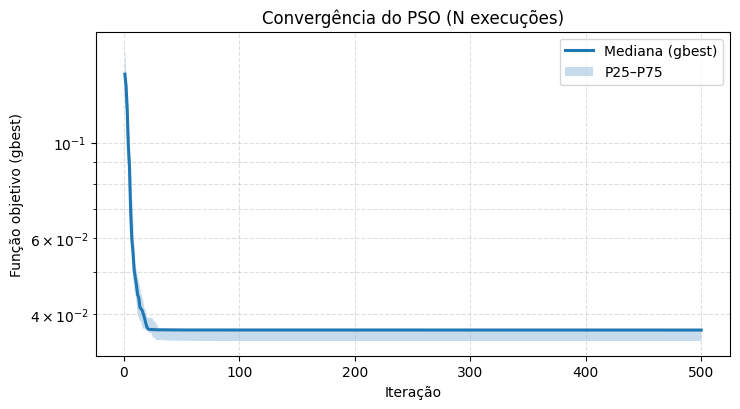

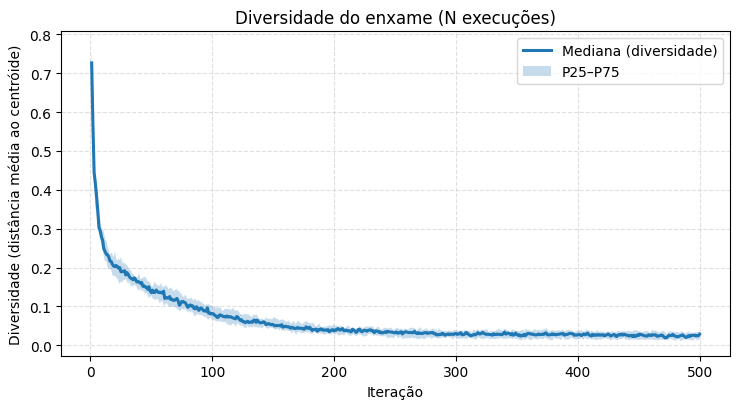

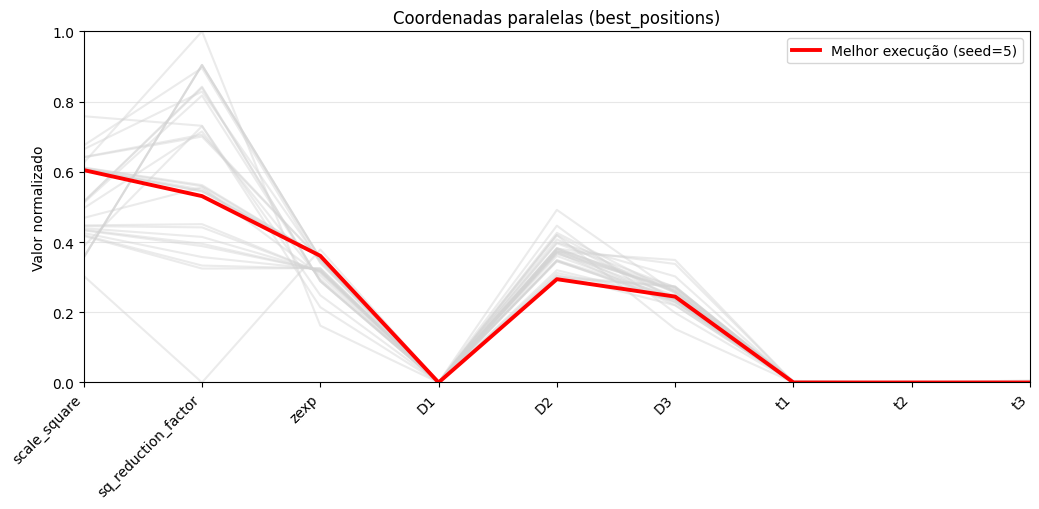

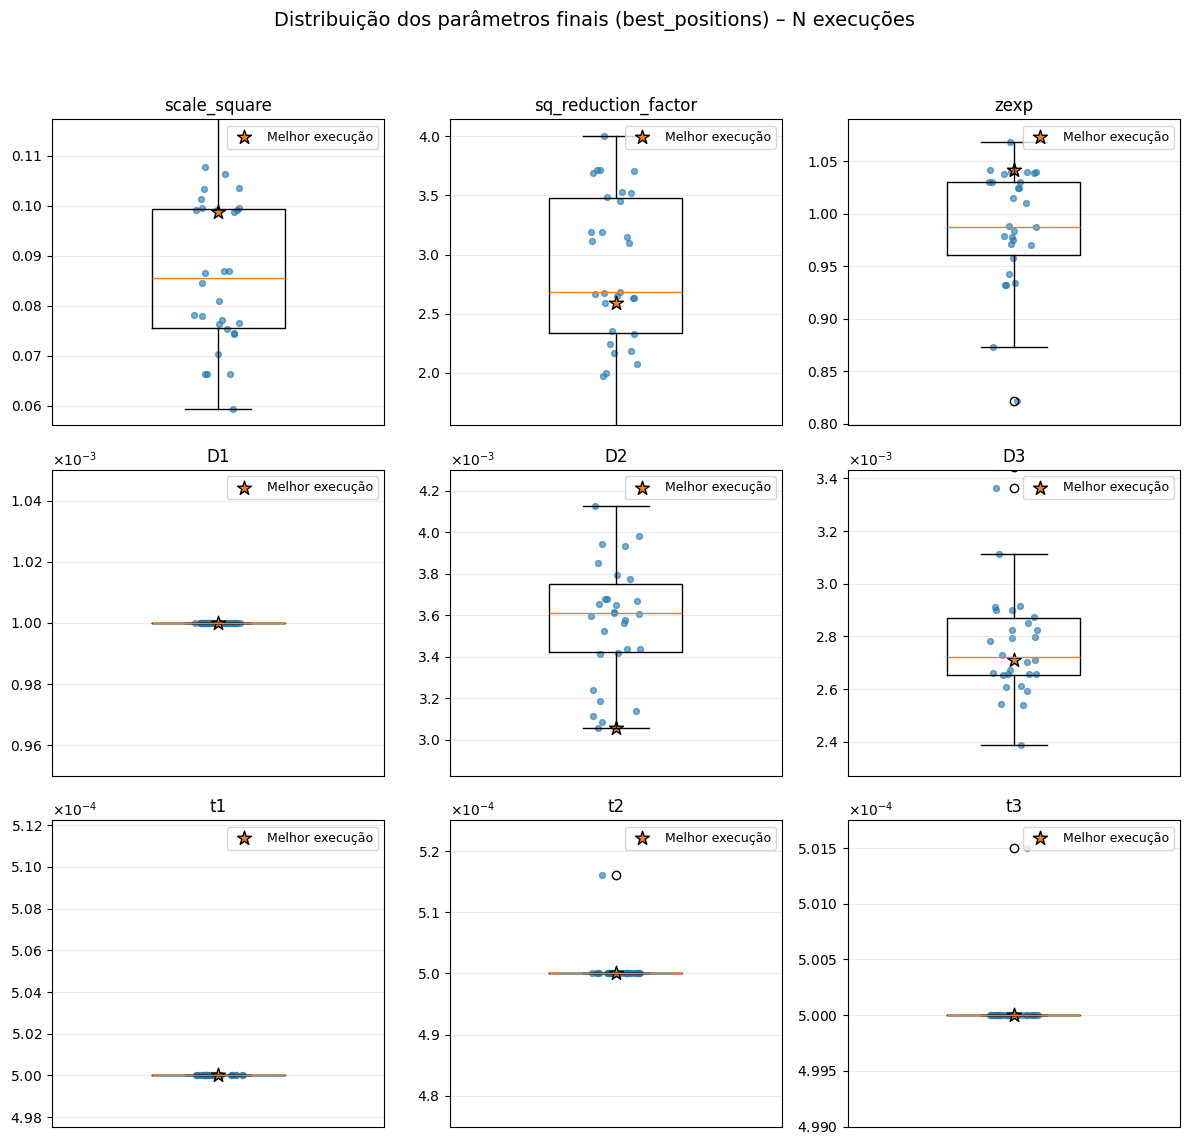


===== BEST_POSITION (para colar no visual se quiser) =====
[9.86293547e-02 2.59211847e+00 1.04114397e+00 1.00000000e-03
 3.05959058e-03 2.71186538e-03 5.00000000e-04 5.00000000e-04
 5.00000000e-04]
best_value = 3.464591e-02



In [21]:
# =========================================
# BLOCO 10 — MAIN (PSO “ARTIGO” + SINGLE) [COMPLETO]
# (usa: run_article_mode, print_article_summary, plot_convergence_band,
#  plot_diversity_band, plot_parallel_coordinates_best, plot_boxplots_best)
# =========================================

RUN_PSO = True                 # True = roda PSO aqui; False = você define best_position manualmente
ARTICLE_MODE = True            # True = N execuções; False = 1 execução
N_RUNS = 30                    # usado no ARTICLE_MODE
SHOW_ARTICLE_PLOTS = True      # plota P25–P75, diversidade, paralelas, boxplots

# se RUN_PSO=False, cole aqui seu best_position (9 valores)
best_position = None
best_value = None

if RUN_PSO:
    if ARTICLE_MODE:
        seeds = list(range(N_RUNS))

        pso_kwargs = dict(
            num_particles=100,
            max_iterations=500,
            w=0.9, w_min=0.4, inertia_scheme="nonlinear",
            c1=1.4, c2=1.8
        )

        results = run_article_mode(N_RUNS, seeds, pso_kwargs)
        print_article_summary(results)

        vals = np.array(results["best_values"], dtype=float)
        idx = int(np.nanargmin(vals))

        best_position = np.array(results["best_positions"][idx], dtype=float)
        best_value = float(vals[idx])

        if SHOW_ARTICLE_PLOTS:
            plot_convergence_band(results)
            plot_diversity_band(results)
            plot_parallel_coordinates_best(results)
            plot_boxplots_best(results, zoom_quantiles=(5, 95), pad_frac=0.25)
            plt.show()

    else:
        np.random.seed(42)

        pso = PSO(
            objective_function, dimensions, bounds,
            num_particles=100,
            max_iterations=500,
            w=0.9, w_min=0.4, inertia_scheme="nonlinear",
            c1=1.4, c2=1.8
        )

        best_position, best_value = pso.optimize()
        best_position = np.array(best_position, dtype=float)
        best_value = float(best_value)

        print("\nOptimization Complete!")
        print(f"Best found position: {best_position}")
        print(f"Best objective function value: {best_value:.6e}")

# sanity de saída
if best_position is None or len(best_position) != 9:
    raise ValueError("best_position inválido. Defina RUN_PSO=True ou cole um best_position com 9 valores.")

print("\n===== BEST_POSITION (para colar no visual se quiser) =====")
print(best_position)
print(f"best_value = {best_value:.6e}")
print("=========================================================\n")
